In [ ]:
import os
import re
import time
import random
import math
import requests
import json
import pandas as pd
from tqdm import tqdm
from dotenv import load_dotenv
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import Select
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities

In [ ]:
# 读取需要的环境变量
load_dotenv()
# link info
# 样品检测信息
ZMJL_PAGE = os.getenv('ZMJL_PAGE')
ZMJL_PAGE_TAIL = os.getenv('ZMJL_PAGE_TAIL')

# 表层样品
BC_PCH_DSH_URL = os.getenv('BC_PCH_DSH_URL')
BC_PCH_YSH_URL = os.getenv('BC_PCH_YSH_URL')

BC_PCH_DSH_PAGE_URL = os.getenv('BC_PCH_DSH_PAGE_URL')
BC_PCH_YSH_PAGE_URL = os.getenv('BC_PCH_YSH_PAGE_URL')
BC_PCH_PAGE_URL_TAIL = os.getenv('BC_PCH_PAGE_URL_TAIL')

# 剖面样品

PM_PCH_DSH_URL = os.getenv('PM_PCH_DSH_URL')
PM_PCH_YSH_URL = os.getenv('PM_PCH_YSH_URL')

PM_PCH_DSH_PAGE_URL = os.getenv('PM_PCH_DSH_PAGE_URL')
PM_PCH_YSH_PAGE_URL = os.getenv('PM_PCH_YSH_PAGE_URL')
PM_PCH_PAGE_URL_TAIL = os.getenv('PM_PCH_PAGE_URL_TAIL')

# 水团样品
ST_PCH_DSH_URL = os.getenv('ST_PCH_DSH_URL')
ST_PCH_YSH_URL = os.getenv('ST_PCH_YSH_URL')

ST_PCH_DSH_PAGE_URL = os.getenv('ST_PCH_DSH_PAGE_URL')
ST_PCH_YSH_PAGE_URL = os.getenv('ST_PCH_YSH_PAGE_URL')
ST_PCH_DSH_PAGE_URL_TAIL = os.getenv('ST_PCH_DSH_PAGE_URL_TAIL')

# 检测结果
JCJG_WLZB_PAGE = os.getenv('JCJG_WLZB_PAGE') 
JCJG_HXZB_PAGE = os.getenv('JCJG_HXZB_PAGE') 
JCJG_PAGE_MID = os.getenv('JCJG_PAGE_MID')
JCJG_PAGE_TAIL = os.getenv('JCJG_PAGE_TAIL')
# headers info 
headers = {
    "Accept": os.getenv("ACCEPT"),
    "Accept-Encoding": os.getenv("ACCEPT_ENCODING"),
    "Accept-Language": os.getenv("ACCEPT_LANGUAGE"),
    "Authorization": os.getenv("AUTHORIZATION"),
    "Connection": os.getenv("CONNECTION"),
    "Cookie": os.getenv("COOKIE"),
    "Host": os.getenv("HOST"),
    "Referer": os.getenv("REFERER"),
    "Sec-Ch-Ua": os.getenv("SEC_CH_UA"),
    "Sec-Ch-Ua-Mobile": os.getenv("SEC_CH_UA_MOBILE"),
    "Sec-Ch-Ua-Platform": os.getenv("SEC_CH_UA_PLATFORM"),
    "Sec-Fetch-Dest": os.getenv("SEC_FETCH_DEST"),
    "Sec-Fetch-Mode": os.getenv("SEC_FETCH_MODE"),
    "Sec-Fetch-Site": os.getenv("SEC_FETCH_SITE"),
    "User-Agent": os.getenv("USER_AGENT")}


In [ ]:
# 获取当前页面cookie信息
def get_cookie():
    """获取当前页面cookie信息"""
    # 使用JavaScript获取Cookie
    cookie_script = """
    return document.cookie;
    """
    cookie_value = driver.execute_script(cookie_script)
    return cookie_value
# 更新cookie信息
def update_cookie(headers):
    """更新cookie信息"""
    # 获取当前页面cookie信息
    cookie_value = get_cookie()
    # 更新headers
    headers.update({"Cookie": cookie_value})
    return headers

# 获取转码记录总数量
def get_trans_num(headers):
    """获取当前转码记录总数量"""
    url = f'{ZMJL_PAGE}1{ZMJL_PAGE_TAIL}'
    # 发送GET请求
    response = requests.get(url, headers=headers)
    # 检查响应状态码
    if response.status_code == 200:
        # 解析响应内容
        data = response.json()
        return data['result']['total']
    else:
        print("请求失败，状态码：", response.status_code)
        return False
    
# 获取转码信息
def get_trans_info(page_number,headers):
    """获取当前页面转码信息"""
    url = f'{ZMJL_PAGE}{page_number}{ZMJL_PAGE_TAIL}'
    # 发送GET请求
    response = requests.get(url, headers=headers)
    # 检查响应状态码
    if response.status_code == 200:
        # 解析响应内容
        data = response.json()
        return data['result']['records']
    else:
        print("请求失败，状态码：", response.status_code)
# 获取各状态审核数量
def get_status_num(type_url,headers):
    """获取各状态审核数量"""
    # 发送GET请求
    response = requests.get(type_url, headers=headers)
    # 检查响应状态码
    if response.status_code == 200:
        # 解析响应内容
        data = response.json()
        return data['result']['count']
    else:
        print("请求失败，状态码：", response.status_code)
        return False
# 获取指定状态指定页面的批次信息及批次编码
def get_status_pc_info(url,headers):
    """获取指定页面的批次编码"""
    response = requests.get(url, headers=headers)
    # 检查响应状态码
    if response.status_code == 200:
        # 解析响应内容
        data = response.json()
        info_list = data['result']['records']
        return info_list
    else:
        print("请求失败，状态码：", response.status_code)
        return False    

# 获取指定批次号下的物理指标
def get_physical_info(url,headers):
    """获取指定批次号下的物理指标"""
    response = requests.get(url, headers=headers)
    # 检查响应状态码
    if response.status_code == 200:
        # 解析响应内容
        data = response.json()
        return data['result']['records'],data['result']['total']
    else:
        print("请求失败，状态码：", response.status_code)
        return False
    
# 获取指定批次号下的化学指标
def get_chemical_info(url,headers):
    """获取指定批次号下的化学指标"""
    response = requests.get(url, headers=headers)
    # 检查响应状态码
    if response.status_code == 200:
        # 解析响应内容
        data = response.json()
        return data['result']['records'],data['result']['total']
    else:
        print("请求失败，状态码：", response.status_code)
        return False

In [ ]:
# 配置浏览器
# chrome.exe --remote-debugging-port=9999 --user-data-dir="D:\Selenium\AutomationProfile"
# chrome.exe --remote-debugging-port=9999 --user-data-dir="D:\Program Files\ChromeDir"
options = webdriver.ChromeOptions()
options.add_experimental_option("debuggerAddress", "localhost:9998")
driver = webdriver.Chrome(options=options)

driver.implicitly_wait(60)

In [ ]:
# 保存路径
save_path = r"F:\collection_spb_info\ZK\BC"
# 如果没有该文件夹，则创建
if not os.path.exists(save_path):
    os.makedirs(save_path)

In [ ]:
# 表层样各状态审核数量
headers = update_cookie(headers)
bc_wait_number = get_status_num(BC_PCH_DSH_URL,headers)
bc_audi_number = get_status_num(BC_PCH_YSH_URL,headers)

In [ ]:
bc_wait_number,bc_audi_number

In [ ]:
# 更新headers
headers = update_cookie(headers)
bc_wait_info_list = []
bc_wait_pcnum_list = []
# 获取表层待审核批次信息
for one_loop in tqdm(range(math.ceil(bc_wait_number/50))):
    temp_bc_wait_info = get_status_pc_info(f'{BC_PCH_DSH_PAGE_URL}{one_loop+1}{BC_PCH_PAGE_URL_TAIL}',headers)
    temp_bc_wait_pc_num = [_['pch'] for _ in temp_bc_wait_info]
    bc_wait_info_list.extend(temp_bc_wait_info)
    bc_wait_pcnum_list.extend(temp_bc_wait_pc_num)

In [ ]:
# 更新headers
headers = update_cookie(headers)
bc_audit_info_list = []
bc_audit_pcnum_list = []
# 获取表层已审核批次信息
for one_loop in tqdm(range(math.ceil(bc_audi_number/50))):
    temp_bc_audit_info = get_status_pc_info(f'{BC_PCH_YSH_PAGE_URL}{one_loop+1}{BC_PCH_PAGE_URL_TAIL}',headers)
    temp_bc_audit_pc_num = [_['pch'] for _ in temp_bc_audit_info]
    bc_audit_info_list.extend(temp_bc_audit_info)
    bc_audit_pcnum_list.extend(temp_bc_audit_pc_num)

In [ ]:
# 对比待审核批次号信息
# step1 读取已有待审核批次号信息
with open(os.path.join(save_path,'bc_dsh_366.json'), 'r') as f:
    bc_wait_pcnum_list_loaded = json.load(f)
# 检查是否为新增批次号
update_bc_wait_pcnum_list = []
for one_loop in bc_wait_pcnum_list:
    if one_loop in bc_wait_pcnum_list_loaded:
        pass
    else:
        update_bc_wait_pcnum_list.append(one_loop)
len(update_bc_wait_pcnum_list)

In [ ]:
# 对比已审核批次号信息
# step1 读取已有已审核批次号信息
with open(os.path.join(save_path,'bc_ysh_385.json'), 'r') as f:
    bc_audit_pcnum_list_loaded = json.load(f)
# 检查是否为新增批次号
update_bc_audit_pcnum_list = []
for one_loop in bc_audit_pcnum_list:
    if one_loop in bc_audit_pcnum_list_loaded:
        pass
    else:
        update_bc_audit_pcnum_list.append(one_loop)
len(update_bc_audit_pcnum_list)

In [ ]:
# 保存待审核批次号
with open(os.path.join(save_path,f'bc_dsh_{len(bc_wait_pcnum_list)}.json'), 'w') as f:
    json.dump(bc_wait_pcnum_list, f, indent=4)
# 保存已审核批次号
with open(os.path.join(save_path,f'bc_ysh_{len(bc_audit_pcnum_list)}.json'), 'w') as f:
    json.dump(bc_audit_pcnum_list, f, indent=4)

In [ ]:
# 更新表层所有批次基础信息
update_bc_wait_info_list = [_ for _ in bc_wait_info_list if _['pch'] in update_bc_wait_pcnum_list]
update_bc_audit_info_list = [_ for _ in bc_audit_info_list if _['pch'] in update_bc_audit_pcnum_list]
update_bc_all_info_list = update_bc_wait_info_list+update_bc_audit_info_list
update_df_bc_info = pd.DataFrame(update_bc_all_info_list)
update_df_bc_info.head(1)

In [ ]:
# 读取已有的数据
df_bc_info = pd.read_excel(os.path.join(save_path, 'bc_info.xlsx'))
# 先将两个DataFrame中需要保持文本格式的数值列转换为字符串类型
df_bc_info = df_bc_info.applymap(str)
update_df_bc_info = update_df_bc_info.applymap(str)
# 合并两个数据
complete_bc_info = pd.concat([df_bc_info,update_df_bc_info],axis=0,ignore_index=True)
# 更新表层待审核数据
complete_bc_info.to_excel(os.path.join(save_path, 'bc_info.xlsx'),index=False)

In [ ]:
# 更新获取表层物理指标
update_bc_physical_info_list = []
update_bc_all_pcnum_list = update_bc_audit_pcnum_list+update_bc_wait_pcnum_list
# 更新headers
headers = update_cookie(headers)
for one_loop in tqdm(update_bc_all_pcnum_list):
    url = f'{JCJG_WLZB_PAGE}{JCJG_PAGE_MID}{one_loop}{JCJG_PAGE_TAIL}'
    # 获取指标信息
    bc_physical_info = get_physical_info(url, headers)
    # 检测是否包含完整个批次数据
    if bc_physical_info[1] <= 50:
        update_bc_physical_info_list.extend(bc_physical_info[0])
    else:
        print(f'{one_loop}批次数据获取得到{bc_physical_info[1]}条，请检查!')
        break

In [ ]:
update_df_bc_physical_info =pd.DataFrame(update_bc_physical_info_list)
update_df_bc_physical_info.head(1)

In [ ]:
# 读取已有的数据
df_bc_physical_info = pd.read_excel(os.path.join(save_path, 'bc_physical_info3.xlsx'))
# 先将两个DataFrame中需要保持文本格式的数值列转换为字符串类型
df_bc_physical_info = df_bc_physical_info.applymap(str)
update_df_bc_physical_info = update_df_bc_physical_info.applymap(str)

# 合并数据
complete_bc_physical_info =pd.concat([df_bc_physical_info,update_df_bc_physical_info],axis=0,ignore_index=True)
# 保存数据
complete_bc_physical_info.to_excel(os.path.join(save_path, 'bc_physical_info4.xlsx'),index=False)

In [ ]:
# 获取表层化学指标
update_bc_chemical_info_list = []
# 更新headers
headers = update_cookie(headers)
for one_loop in tqdm(update_bc_all_pcnum_list):
    url = f'{JCJG_HXZB_PAGE}{JCJG_PAGE_MID}{one_loop}{JCJG_PAGE_TAIL}'
    # 获取指标信息
    bc_chemical_info = get_chemical_info(url, headers)
    # 检测是否包含完整个批次数据
    if bc_chemical_info[1] <= 50:
        update_bc_chemical_info_list.extend(bc_chemical_info[0])
    else:
        print(f'{one_loop}批次数据获取得到{bc_chemical_info[1]}条，请检查!')
        break

In [ ]:
update_df_bc_chemical_info =pd.DataFrame(update_bc_chemical_info_list)
update_df_bc_chemical_info.head(1)

In [ ]:
# 读取已有的数据
df_bc_chemical_info = pd.read_excel(os.path.join(save_path, "bc_chemical_info3.xlsx"))
# 先将两个DataFrame中需要保持文本格式的数值列转换为字符串类型
df_bc_chemical_info = df_bc_chemical_info.applymap(str)
update_df_bc_chemical_info = update_df_bc_chemical_info.applymap(str)
# 合并数据
complete_df_bc_chemical_info = pd.concat([df_bc_chemical_info,update_df_bc_chemical_info],axis=0,ignore_index=True)
# 保存数据
complete_df_bc_chemical_info.to_excel(os.path.join(save_path, "bc_chemical_info4.xlsx"),index=False)

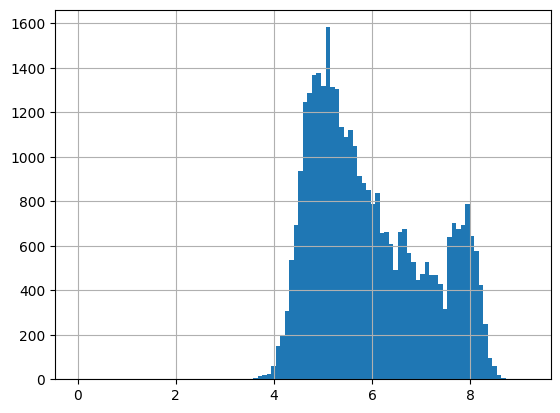

In [34]:
import matplotlib.pyplot as plt
histogram = complete_df_bc_chemical_info['ph'].astype(float).hist(bins=100)
plt.show()

In [38]:
complete_df_bc_chemical_info['ph'].astype(float).describe()

count    35948.000000
mean         5.953672
std          1.152428
min          0.000000
25%          5.010000
50%          5.680000
75%          6.830000
max          9.180000
Name: ph, dtype: float64